In [1]:
import os
import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import warnings
from datetime import timedelta
from IPython.display import clear_output
from tensorflow.keras.backend import set_session

from utils import *
from model import *

tf.reset_default_graph()

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True
# to log device placement (on which device the operation ran)
config.log_device_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.Session(config=config)
# set this TensorFlow session as the default session for Keras
set_session(sess)

In [2]:
BATCH_SIZE = 128
model_name = time.strftime('%Y-%m-%d_%H:%M:%S_%z') + "_" + str(BATCH_SIZE)
output_dir = "output"
model_dir = '{}/{}'.format(output_dir, model_name)
image_dir = '{}/images'.format(model_dir)
checkpoints_dir = '{}/checkpoints'.format(model_dir)
for path in [output_dir, model_dir, image_dir, checkpoints_dir]:
    if not os.path.exists(path):
        os.mkdir(path)

In [3]:
'''
!wget 'https://gitlab.com/federicozzo/attgan/raw/master/resources/train.tfrecords.zip'
!wget 'https://gitlab.com/federicozzo/attgan/raw/master/resources/test.tfrecords.zip'  
!unzip train.tfrecords.zip
!rm -f 'train.tfrecords.zip'
!unzip test.tfrecords.zip 
!rm -f 'test.tfrecords.zip' 
!mkdir resources 
!mv 'test.tfrecords' resources
!mv 'train.tfrecords' resources 
'''

"\n!wget 'https://gitlab.com/federicozzo/attgan/raw/master/resources/train.tfrecords.zip'\n!wget 'https://gitlab.com/federicozzo/attgan/raw/master/resources/test.tfrecords.zip'  \n!unzip train.tfrecords.zip\n!rm -f 'train.tfrecords.zip'\n!unzip test.tfrecords.zip \n!rm -f 'test.tfrecords.zip' \n!mkdir resources \n!mv 'test.tfrecords' resources\n!mv 'train.tfrecords' resources \n"

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 128
NUM_CLASSES = 1
EPOCHS = 20
GENERATION_RATE = 2
LEARNING_RATE = 0.002
BETA_1 = 0.5
BETA_2 = 0.999

# data input

In [5]:
""" load TFRecordDataset """
training_data = Barkley_Deep_Drive('../../self-driving-AttGAN/resources/train.tfrecords')
validation_data = Barkley_Deep_Drive('../../self-driving-AttGAN/resources/test.tfrecords')

train_iterator = training_data.get_batch(EPOCHS, BATCH_SIZE, shuffle = False)
val_iterator = validation_data.get_batch(EPOCHS, BATCH_SIZE, shuffle = False)

train_image_iterator, train_label_iterator = train_iterator.get_next()
val_image_iterator, val_label_iterator = val_iterator.get_next()



W1208 16:52:57.163556 140620971771712 deprecation_wrapper.py:119] From /home/ec2-user/attgan/code/utils.py:24: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W1208 16:52:57.164558 140620971771712 deprecation_wrapper.py:119] From /home/ec2-user/attgan/code/utils.py:28: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



In [6]:
sess.run(train_iterator.initializer)
image_batch, label_batch = sess.run([train_image_iterator, train_label_iterator])

In [7]:
thres_int = 0.5

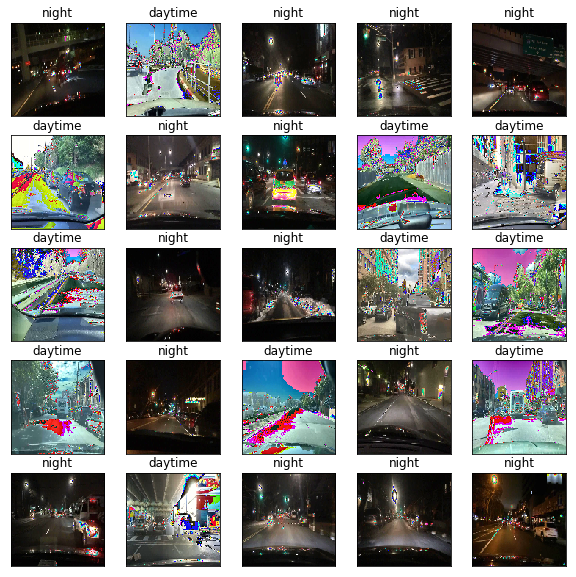

In [8]:
number_of_images = 5

plt.figure(1, figsize=(number_of_images*2,number_of_images*2))
for ind, i in enumerate(range(number_of_images**2)):
    plt.subplot(number_of_images,number_of_images,i+1)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.imshow((image_batch[i] * 255).astype(np.uint8))
    plt.title(label_batch[i].decode("utf-8"))

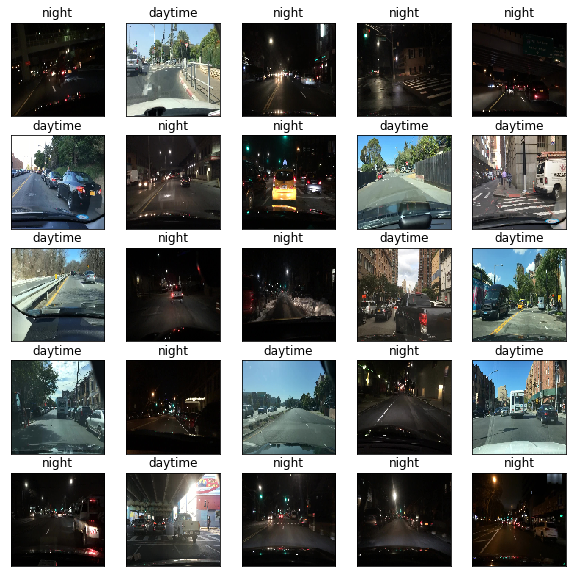

In [11]:
number_of_images = 5

plt.figure(1, figsize=(number_of_images*2,number_of_images*2))
for ind, i in enumerate(range(number_of_images**2)):
    plt.subplot(number_of_images,number_of_images,i+1)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.imshow((image_batch[i] * 255).astype(np.uint8))
    plt.title(label_batch[i].decode("utf-8"))

In [9]:
xa = tf.placeholder(tf.float32,shape=[BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3],name="xa") #orignal image
z = encoder(xa, reuse=tf.AUTO_REUSE) #encoder output

a = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="a") #original attributes
b = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="b") #desired attributes

xb_hat = decoder(z, b, reuse=tf.AUTO_REUSE) #decoder output
with tf.control_dependencies([xb_hat]):
    xa_hat = decoder(z, a, reuse=tf.AUTO_REUSE) #decoder output

xa_logit_D, xa_logit_C = classifier_and_discriminator(xa, reuse=tf.AUTO_REUSE)
xb_logit_D, xb_logit_C = classifier_and_discriminator(xb_hat, reuse=tf.AUTO_REUSE)

W1208 16:53:08.660651 140620971771712 deprecation_wrapper.py:119] From /home/ec2-user/attgan/code/model.py:83: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1208 16:53:08.661902 140620971771712 deprecation_wrapper.py:119] From /home/ec2-user/attgan/code/model.py:54: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1208 16:53:10.735630 140620971771712 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1208 16:53:11.126313 140620971771712 deprecation.py:323] From /home/ec2-user/attgan/code/model.py:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will

In [10]:
# interpolated image
epsilon = tf.random_uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
interpolated_image = xa + epsilon * (xb_hat - xa)
c_interpolated, d_interpolated = classifier_and_discriminator(interpolated_image, reuse=tf.AUTO_REUSE)

W1208 16:53:12.469727 140620971771712 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


# discriminator losses

In [11]:
lambda_ = {"3" : 1, "2" : 10, "1" : 100}

In [12]:
loss_adv_D =  - ( tf.reduce_mean(xa_logit_D) - tf.reduce_mean(xb_logit_D) )  

grad_d_interpolated = tf.gradients(d_interpolated, [interpolated_image])[0]
slopes = tf.sqrt(1e-10 + tf.reduce_sum(tf.square(grad_d_interpolated), axis=[1, 2, 3]))
gp = tf.reduce_mean((slopes - 1.) ** 2)

loss_cls_C = tf.losses.sigmoid_cross_entropy(a, xa_logit_C)

D_loss = loss_adv_D + gp * lambda_['2'] + loss_cls_C 


W1208 16:53:12.936553 140620971771712 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# generator lossses

In [13]:
loss_adv_G = -tf.reduce_mean(xb_logit_D) 
loss_cls_G = tf.losses.sigmoid_cross_entropy(b, xb_logit_C)
loss_rec = tf.losses.absolute_difference(xa, xa_hat)

G_loss =  loss_adv_G + lambda_['2'] * loss_cls_G + lambda_['1'] * loss_rec 

In [14]:
""" Training """
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'C_D' in var.name ]
g_vars = [var for var in t_vars if 'G_' in var.name]
assert(len(t_vars) == len(d_vars ) + len(g_vars )), "mismatch in variable names"

d_optim = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE,
                                 beta1 = BETA_1,
                                 beta2 = BETA_2).minimize(D_loss, var_list=d_vars)

g_optim = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE,
                                 beta1 = BETA_1,
                                 beta2 = BETA_2).minimize(G_loss, var_list=g_vars)

d_summary = summary({
    loss_adv_D: 'loss_adv_D',
    gp: 'gp',
    loss_cls_C: 'loss_cls_C',
}, scope='D_')

g_summary = summary({
    loss_adv_G: 'loss_adv_G',
    loss_cls_G: 'loss_cls_G',
    loss_rec: 'loss_rec',
}, scope='G_')

W1208 16:53:27.859762 140620971771712 deprecation_wrapper.py:119] From /home/ec2-user/attgan/code/utils.py:77: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W1208 16:53:27.862608 140620971771712 deprecation_wrapper.py:119] From /home/ec2-user/attgan/code/utils.py:94: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.



In [16]:
ckpt_dir_or_file = "output/2019-12-06_16:54:00_+0000_64/checkpoints"
var_list = t_vars
if os.path.isdir(ckpt_dir_or_file):
    print("Fiel")
    ckpt_dir_or_file = tf.train.latest_checkpoint(ckpt_dir_or_file)
restorer = tf.train.Saver(var_list)
restorer.restore(sess, ckpt_dir_or_file)
print(' [*] Loading checkpoint succeeds! Copy variables from % s!' % ckpt_dir_or_file)


W1208 16:53:47.195847 140620971771712 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1282: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Fiel
 [*] Loading checkpoint succeeds! Copy variables from output/2019-12-06_16:54:00_+0000_64/checkpoints/Epoch_1_10100.ckpt!


In [20]:
if NUM_CLASSES == 2:
    label_mapping = {'daytime': [1, 0], 'night': [0, 1]}
else:
    label_mapping = {'daytime': [1], 'night': [0]}
    flip = {'1':[0], '0': [1] }

In [21]:
truncated_uniform_scale_flag = False

In [22]:

for epoch_no in tqdm.tqdm(range(EPOCHS), total=EPOCHS):

    sess.run(val_iterator.initializer)
    sess.run(train_iterator.initializer)

    try:
        step = 0
        start_time = time.monotonic()
        d_loss_per_batch = []
        g_loss_per_batch = []
        while True:
            # Sample batch from dataset
            image_batch, label_batch = sess.run([val_image_iterator, val_label_iterator])

            # Transform label batch in our simple one hot encoded version
            a_label_batch = [label_mapping[label.decode("utf-8")] for label in label_batch]#, dtype=np.float64)
            if truncated_uniform_scale_flag:
                b_label_batch = tf.random_shuffle(a_label_batch)
                a_label_batch = (tf.to_float(a_label_batch) * 2 - 1) * thres_int
                b_label_batch = (tf.to_float(b_label_batch) * 2 - 1) * (tf.truncated_normal(tf.shape(b_label_batch)) + 2) / 4.0 * (2 * thres_int)
                a_label_batch = sess.run(a_label_batch)
                b_label_batch = sess.run(b_label_batch)
            else:
                b_label_batch = [flip[str(label[0])] for label in a_label_batch]
                a_label_batch = np.asarray(a_label_batch, dtype=np.float32)
                b_label_batch = np.asarray(b_label_batch, dtype=np.float32)

            # Optimize
            d_summary_opt, _, D_loss_val = sess.run([d_summary, d_optim, D_loss], feed_dict={xa:image_batch,
                                                                    a: a_label_batch, b: b_label_batch})
            if step % 5 == 0 or step == 0:
                g_summary_opt, _, G_loss_val = sess.run([g_summary, g_optim, G_loss], feed_dict={xa:image_batch,
                                                                    a: a_label_batch, b: b_label_batch})

            d_loss_per_batch.append(D_loss_val)
            g_loss_per_batch.append(G_loss_val)

            summary_writer.add_summary(d_summary_opt, epoch_no)
            summary_writer.add_summary(g_summary_opt, epoch_no)

            if step % 500 == 0:
                print("At step ", step, "we have")
                print("Gen loss: ",np.mean(g_loss_per_batch), " and Desc loss:", np.mean(d_loss_per_batch) , "\n ")
                S_.ParseFromString(d_summary_opt)
                print(S_)
                S_.ParseFromString(g_summary_opt)
                print(S_)

            step += 1
    except tf.errors.OutOfRangeError:
            checkpoint_save_path = saver.save(sess, '{}/Epoch_{}_{}.ckpt'.format(checkpoints_dir, str(epoch_no), str(step)))
            print('Model is saved at {}!'.format(checkpoint_save_path))

            # Generating reconstructed image xa_hat and flipped attribute image xb_hat
            image_batch, label_batch = sess.run([train_image_iterator, train_label_iterator])

            # Transform label batch in our simple one hot encoded version
            a_label_batch = np.array([label_mapping[label.decode("utf-8")] for label in label_batch])#, dtype=np.float64)
            if truncated_uniform_scale_flag:
                b_label_batch = tf.random_shuffle(a_label_batch)
                a_label_batch = (a_label_batch * 2 - 1) * thres_int
                b_label_batch = (tf.to_float(b_label_batch) * 2 - 1) * (tf.truncated_normal(tf.shape(b_label_batch)) + 2) / 4.0 * (2 * thres_int)
                b_label_batch = sess.run(b_label_batch)
            else:
                b_label_batch = [flip[str(label[0])] for label in a_label_batch]
                a_label_batch = np.asarray(a_label_batch, dtype=np.float32)
                b_label_batch = np.asarray(b_label_batch, dtype=np.float32)

            step_xb_hat = sess.run(xb_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})
            step_xa_hat = sess.run(xa_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})
            # Saving images:
            output_path = os.path.join(image_dir, "epoch_no_"+ str(epoch_no) +"_")

            plt.imsave(output_path+"xa_original.png", image_batch[0])
            plt.imsave(output_path+"xa_hat.png", step_xa_hat[0])
            plt.imsave(output_path+"xb_hat.png", step_xb_hat[0])

            end_time = time.monotonic()
            print("END OF EPOCH")
            fmt = "Epoch duration: {}".format(timedelta(seconds=end_time - start_time))
            print(fmt)
            d_loss_epoch.append(np.mean(d_loss_per_batch))
            g_loss_epoch.append(np.mean(g_loss_per_batch))
            print("Discriminator loss: ", d_loss_epoch[-1])
            print("Generator loss: ", g_loss_epoch[-1])
            print("-"*len(fmt))
            pass


  0%|          | 0/20 [00:07<?, ?it/s]


FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Attempting to use uninitialized value C_D/LayerNorm_2/gamma
	 [[node C_D/LayerNorm_2/gamma/read (defined at /home/ec2-user/attgan/code/model.py:19) ]]
	 [[Neg/_13]]
  (1) Failed precondition: Attempting to use uninitialized value C_D/LayerNorm_2/gamma
	 [[node C_D/LayerNorm_2/gamma/read (defined at /home/ec2-user/attgan/code/model.py:19) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'C_D/LayerNorm_2/gamma/read':
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-5cdf3d57e2b2>", line 11, in <module>
    xa_logit_D, xa_logit_C = classifier_and_discriminator(xa, reuse=tf.AUTO_REUSE)
  File "/home/ec2-user/attgan/code/model.py", line 19, in classifier_and_discriminator
    layer_norm = tf.contrib.layers.layer_norm(conv)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 2315, in layer_norm
    trainable=trainable)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 355, in model_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 283, in variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 562, in get_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
for epoch_no in tqdm.tqdm(range(EPOCHS), total=EPOCHS): 
    
    sess.run(val_iterator.initializer)
    sess.run(train_iterator.initializer)
    
    try:
        step = 0
        start_time = time.monotonic()
        d_loss_per_batch = []
        g_loss_per_batch = []
        while True:
            clear_output(wait=True)
            print(step)
            # Sample batch from dataset
            image_batch, label_batch = sess.run([val_image_iterator, val_label_iterator])

            # Transform label batch in our simple one hot encoded version
            a_label_batch = [label_mapping[label.decode("utf-8")] for label in label_batch]#, dtype=np.float64)
            b_label_batch = [flip[str(label[0])] for label in a_label_batch]

            a_label_batch = np.asarray(a_label_batch, dtype=np.float32)
            b_label_batch = np.asarray(b_label_batch, dtype=np.float32)

            # Optimize
            d_summary_opt, _, D_loss_val = sess.run([d_summary, d_optim, D_loss], feed_dict={xa:image_batch,
                                                                            a: a_label_batch, b: b_label_batch}) 
            g_summary_opt, _, G_loss_val = sess.run([g_summary, g_optim, G_loss], feed_dict={xa:image_batch,
                                                                    a: a_label_batch, b: b_label_batch})

            d_loss_per_batch.append(D_loss_val)
            g_loss_per_batch.append(G_loss_val)

            summary_writer.add_summary(d_summary_opt, epoch_no)
            summary_writer.add_summary(g_summary_opt, epoch_no)

            if step % 500 == 0:
                print("At step ", step, "we have")
                print("Gen loss: ",np.mean(g_loss_per_batch), " and Desc loss:", np.mean(d_loss_per_batch) , "\n ")
                S_.ParseFromString(d_summary_opt)
                print(S_)
                S_.ParseFromString(g_summary_opt)
                print(S_)

            step += 1
    except tf.errors.OutOfRangeError:
            end_time = time.monotonic()
            print("END OF EPOCH")
            fmt = "Epoch duration: {}".format(timedelta(seconds=end_time - start_time))
            print(fmt)
            d_loss_epoch.append(np.mean(d_loss_per_batch))
            g_loss_epoch.append(np.mean(g_loss_per_batch))
            print("Discriminator loss: ", d_loss_epoch[-1])
            print("Generator loss: ", g_loss_epoch[-1])
            print("-"*len(fmt))
            pass

In [ ]:
def model_dir(model_name, batch_size):
    return "{}_{}".format(model_name, batch_size)

def save(self, saver, sess, checkpoint_dir, model_dir, model_name, step):
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name+'.model'), global_step=step)

def load(self, saver, sess, checkpoint_dir, model_dir, model_name):
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(sess, os.path.join(checkpoint_dir, ckpt_name))
        counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
        print(" [*] Success to read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")


In [ ]:
timedelta(seconds=end_time - start_time)

In [ ]:
step_xb_hat = sess.run(xb_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})

In [ ]:
step_xb_logit_D = sess.run(xb_logit_D, feed_dict={xb_hat:step_xb_hat})
step_xb_logit_C = sess.run(xb_logit_C, feed_dict={xb_hat:step_xb_hat})            

In [ ]:
step_xb_logit_C

In [ ]:
step_xa_hat = sess.run(xa_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})


In [ ]:
step_xa_logit_D = sess.run(xa_logit_D, feed_dict={xa:image_batch})
step_xa_logit_C = sess.run(xa_logit_C, feed_dict={xa:image_batch})


In [ ]:
plt.imshow(step_xa_hat[10])

In [ ]:
plt.imshow(step_xb_hat[10])

In [ ]:
xb_hat = sess.run(xb_hat, feed_dict={a:test_a_label_batch, b:test_b_label_batch, xa:image_train_batch})

In [ ]:
plt.imshow(xb_hat[0])
#plt.title('daytime')

In [ ]:
plt.imshow(train_batch[0])
plt.title(label_batch[0].decode("utf-8"))

In [ ]:
import tensorflow.contrib.slim as slim

In [ ]:
help(slim.fully_connected)

In [16]:
tf.random.set_seed(seed)


AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [18]:
tf.__version__

'1.14.0'

In [20]:
tf.random.set_random_seed(42)

In [1]:
image_dir, "epoch_no_"+ str(epoch_no) +"_" +".png"

NameError: name 'image_dir' is not defined

In [8]:
for epoch_no in range(100,120):
    print("epoch_no_"+ str(epoch_no).zfill(2) +"_" +".png")

epoch_no_100_.png
epoch_no_101_.png
epoch_no_102_.png
epoch_no_103_.png
epoch_no_104_.png
epoch_no_105_.png
epoch_no_106_.png
epoch_no_107_.png
epoch_no_108_.png
epoch_no_109_.png
epoch_no_110_.png
epoch_no_111_.png
epoch_no_112_.png
epoch_no_113_.png
epoch_no_114_.png
epoch_no_115_.png
epoch_no_116_.png
epoch_no_117_.png
epoch_no_118_.png
epoch_no_119_.png
